<a href="https://colab.research.google.com/github/gub4rk/DS4002_CS3/blob/main/CODE/HurricaneAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code is what you require to replicate the study on predicting hurricane activity

# Importing Libraries and The Dataset is the first step

In [1]:
! git clone https://github.com/gub4rk/DS4002_CS3 # allows you to import data from the GitHub

Cloning into 'DS4002_CS3'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 35 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 390.17 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# read in data
data = pd.read_csv("/content/DS4002_CS3/DATA/Hurricane_Dataset.csv", index_col='Year')

# get rid of unneeded columns and take look at data
data = data[data.columns[2:]]
data.head()

,Total_Hurricane_Days,CO2_emissions,Population,CSIRO_Adjusted_SeaLevel_Inch,Surface_Temperature_Change,SurfaceSeaTemp_Annual_Anomaly
Year,,,,,,
1971,67.25,1.550279e+10,3769847834,4.881890,-0.093,-0.519
1972,40.00,1.622344e+10,3844917687,5.240157,-0.199,-0.193
1973,38.50,1.708350e+10,3920805030,5.003937,0.269,-0.151
1974,37.00,1.700938e+10,3996416108,5.472441,-0.181,-0.427
1975,47.25,1.704998e+10,4070735264,5.409449,0.088,-0.445


# Next, we will conduct visualizations so you can familiarize yourself with the data

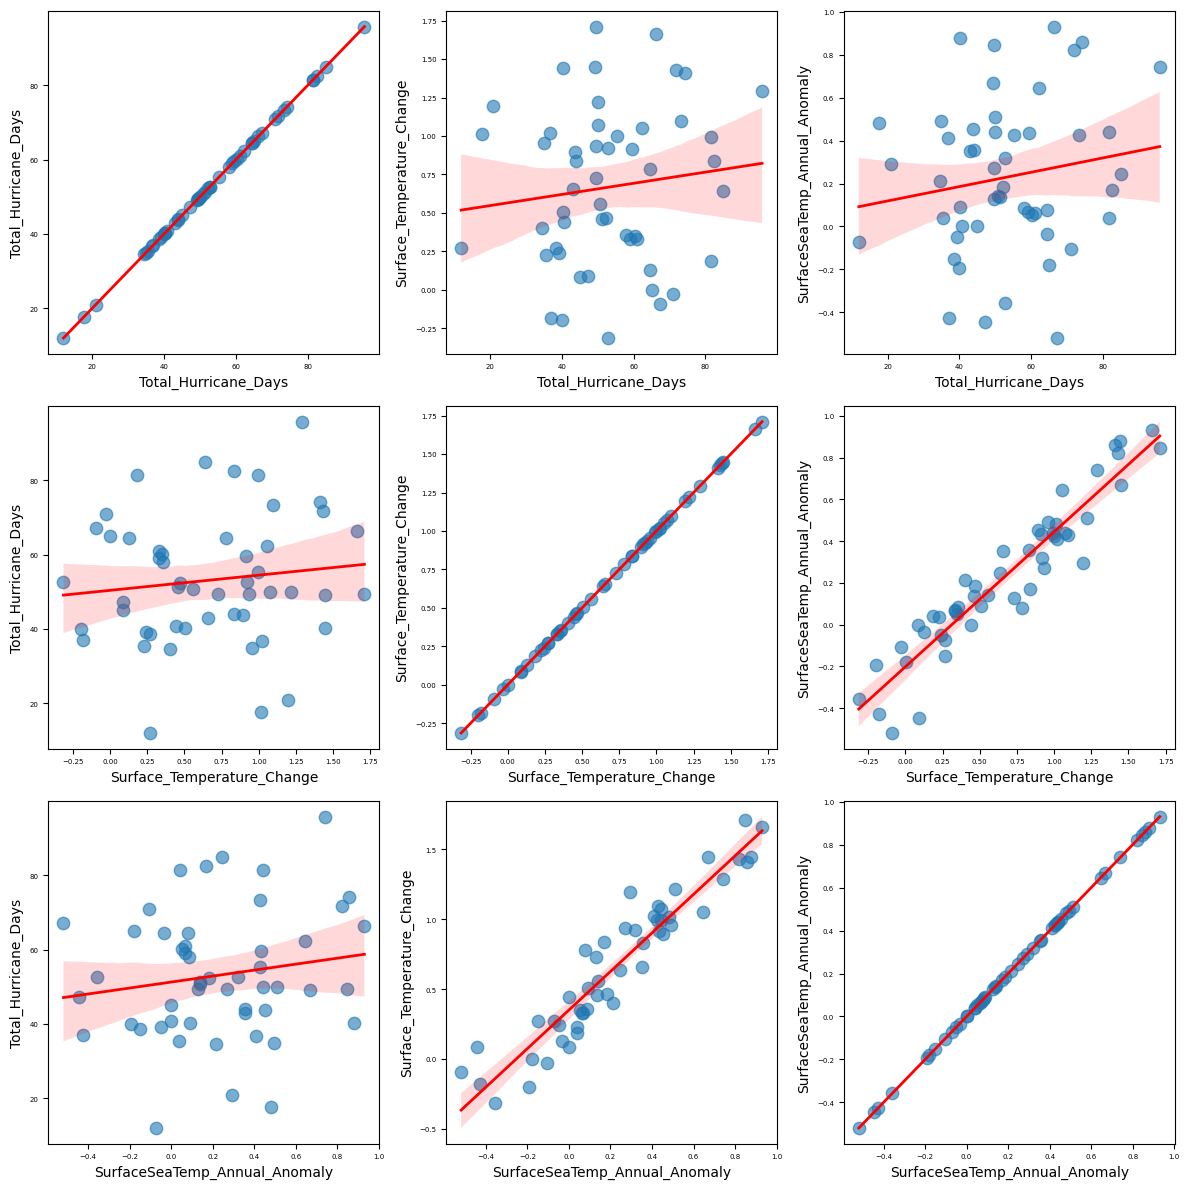

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# makes indexing easier
axes = axes.flatten()

# used for for loop below
variables = ['Total_Hurricane_Days', 'Surface_Temperature_Change', 'SurfaceSeaTemp_Annual_Anomaly']

# selects color palette
palette = sns.color_palette("YlGnBu", as_cmap=True)

# loop through each variable and make scatterplot for each one
plot_idx = 0
for var1 in variables:
    for var2 in variables:
        # adds line of best fit and plot
        sns.regplot(x=var1, y=var2, data=data, ax=axes[plot_idx], scatter_kws={'s': 80, 'alpha': 0.6}, line_kws={'color':"red",'lw': 2})

        # set titles and labels
        axes[plot_idx].set_xlabel(var1, fontsize=10)
        axes[plot_idx].set_ylabel(var2, fontsize=10)

        # remove ticks for clarity
        axes[plot_idx].tick_params(axis='both', which='major', labelsize=5)

        plot_idx += 1

# prevent overlap
plt.tight_layout()

plt.show()

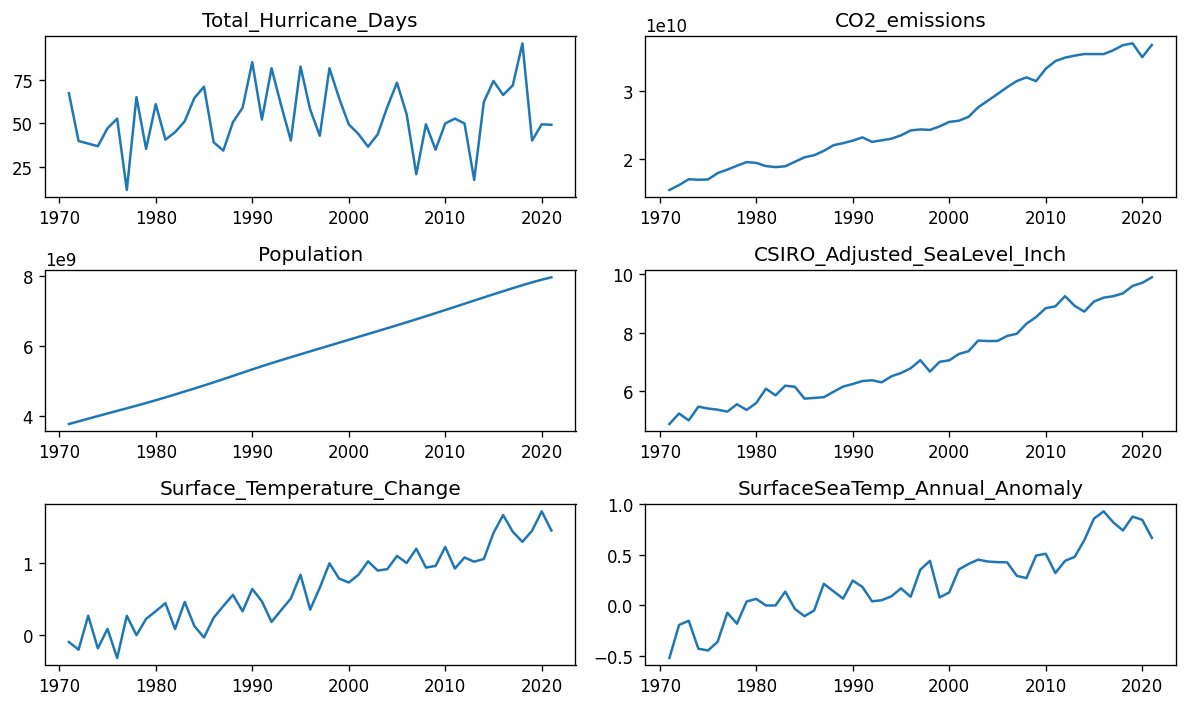

In [4]:
# set up plot structure
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    temp = data[data.columns[i]]
    ax.plot(temp)
    ax.set_title(data.columns[i])

plt.tight_layout();

# Grangers Causality Test
This test tells us if past values of one variables improves predictions of another. When looking at the Total_Hurrricane_Days_Y variable, if the number is statistically significant for all X's (below 0.05), we say that variable X Granger causes variable y. This means our X's are useful in predicting our Y value.

If the p-value is significant, we know that our X's have predictive power and we can continue with our analysis

# Cointegration Test

Next we will conduct the cointegration test. This is important as it tests for long term relationships between the variables even if the variables are non-stationary, and it is an essential initial test for the VAR model.

With the output for each variable being true (statistically significant), we can proceed with the model.

Next, the data will be split into training and testing datasets using the code below:

In [5]:
# split into training and testing datasets
nobs = 4 # we are gonna predict 4 time periods ahead (4 months)
data_train, data_test = data[0:-nobs], data[-nobs:]
print(data_train.shape)
print(data_test.shape)

(47, 6)
(4, 6)


The last assumption for the VAR model is having stationary independent variables. The code below validates this assumption for you using the Augmented-Dickey Fuller Test, so now you can create the VAR model after running this code

In [6]:
def adf_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

# ADF Test on each variable
for name, column in data_train.items():
    adf_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Total_Hurricane_Days" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1822
 No. Lags Chosen       = 0
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO2_emissions" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.7495
 No. Lags Chosen       = 0
 Critical value 1%     = -3.581
 Critical value 5%     = -2.927
 Critical value 10%    = -2.602
 => P-Value = 0.9908. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Population" 
    -----------------------------------------------
 Null Hypothesis: Data has un

As we can see, most of the variables are not stationary, so let's correct this now.

In [7]:
# difference series and re-run ADF test since almost none were stationary
data_traind1 = data_train.diff().dropna()
for name, column in data_traind1.items():
    adf_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Total_Hurricane_Days" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2248
 No. Lags Chosen       = 4
 Critical value 1%     = -3.601
 Critical value 5%     = -2.935
 Critical value 10%    = -2.606
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO2_emissions" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1195
 No. Lags Chosen       = 0
 Critical value 1%     = -3.585
 Critical value 5%     = -2.928
 Critical value 10%    = -2.602
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Population" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.

# VAR Model

Below, you may now create the VAR model using methods of your choice, however I would suggest using AIC scores to compare models and using the durbin watson statistic to check residuals.

# Results and Visualization

You are almost done! Now create a graph containing each variable and comparing the actuals to the forecasts from 2018-2021. Finally, calculate the RMSE to evaluate how the model is performing. Good job!